In [1]:
import calitp
from calitp.tables import tbl
from siuba import *

import pandas as pd
ix = pd.IndexSlice
import numpy as np
import geopandas as gpd

from calenviroscreen_utils import *
from utils import *
import prep_data

import shapely
from shapely.geometry import LineString

import os
from calitp.storage import get_fs
fs = get_fs()

In [2]:
ces_df = prep_data.generate_calenviroscreen_lehd_data(prep_data.datasets)

In [3]:
ces_df['tract_type'] = ces_df['pop_sq_mi'].apply(lambda x: 'urban' if x > 2400 else 'suburban' if x > 800 else 'rural')

In [4]:
service_funding_joined = pd.read_parquet(f"{GCS_FILE_PATH}shape_frequency_funding.parquet")

In [5]:
service_funding_joined.head(3)

,calitp_itp_id,ntd_id,transit_provider,_5307_funds,_5311_funds,operating_expenses_total_2019,shape_id,day_name,departure_hour,route_id,trips_per_hour,mean_runtime_min
0,257,None,PresidioGo Shuttle,0.0,NaN,0.0,13737,Thursday,0,66,0,NaN
1,257,None,PresidioGo Shuttle,0.0,NaN,0.0,13737,Thursday,1,66,0,NaN
2,257,None,PresidioGo Shuttle,0.0,NaN,0.0,13737,Thursday,2,66,0,NaN


In [6]:
dates = get_recent_dates()
min_date = min(dates.values())
max_date = max(dates.values())

In [7]:
def line_from_shape(df):
    '''
    Convert a sequence of shape points for a single gtfs shape into a linestring geometry.
    '''
    try:
        assert df.size > 1, f'no geometry for shape {df.shape_id.iloc[0]}'
        df.shape_pt_sequence = df.shape_pt_sequence.astype('int64')
        df.sort_values(by='shape_pt_sequence', inplace=True) ##arrange, then convert to line to preserve order...
        route_line = LineString(list(df['geometry']))
        df['route_line'] = route_line
        return df
    except AssertionError as err:
        print(err)
        return df

In [8]:
def get_process_shapes():
    all_shapes = gpd.GeoDataFrame()
    for operator in service_funding_joined.calitp_itp_id.unique():

        print(operator)
        try:

            shapes = (tbl.gtfs_schedule.shapes()
                      >> select(_.calitp_itp_id, _.shape_id, _.shape_pt_lat, _.shape_pt_lon,
                               _.shape_pt_sequence)
                      >> filter(_.calitp_itp_id == int(operator))
                      >> collect()
                     )
            shapes_geo = gpd.GeoDataFrame(shapes, 
                                  geometry = gpd.points_from_xy(shapes.shape_pt_lon, shapes.shape_pt_lat),
                                  crs = 'EPSG:4326').to_crs('EPSG:3310') ## https://epsg.io/3310 (meters)
            shape_lined = shapes_geo.groupby(['calitp_itp_id', 'shape_id']).apply(line_from_shape).reset_index(drop=True)
            shape_lined = shape_lined.drop_duplicates(subset=['shape_id'])
            shape_lined = shape_lined[['calitp_itp_id', 'shape_id', 'route_line']]
            shape_lined = gpd.GeoDataFrame(shape_lined, geometry=shape_lined['route_line'], crs='EPSG:3310')
            shape_lined = shape_lined.drop(columns=['route_line'])
            all_shapes = all_shapes.append(shape_lined)
        except:
            print(f'failed for operator {operator}')
    return all_shapes

In [9]:
# all_shapes = get_process_shapes()

In [10]:
def geoparquet_gcs_export(gdf, GCS_FILE_PATH, name):
    '''
    Save geodataframe as parquet locally, 
    then move to GCS bucket and delete local file.
    
    gdf: geopandas.GeoDataFrame
    GCS_FILE_PATH: str. Ex: gs://calitp-analytics-data/data-analyses/my-folder/
    name: str. Filename.
    '''
    gdf.to_parquet(f"./{name}.parquet")
    fs.put(f"./{name}.parquet", f"{GCS_FILE_PATH}{name}.parquet")
    os.remove(f"./{name}.parquet")

In [11]:
# geoparquet_gcs_export(all_shapes, GCS_FILE_PATH, 'shapes_initial')

In [12]:
# all_shapes.to_parquet('./working_shapes.parquet')
all_shapes = gpd.read_parquet(f'{GCS_FILE_PATH}shapes_initial.parquet')

In [13]:
all_shapes.head(3)

,calitp_itp_id,shape_id,geometry
0,257,13737,"LINESTRING (-216058.966 -21114.229, -216058.96..."
344,257,13738,"LINESTRING (-216058.966 -21114.229, -216058.96..."
0,259,p_110998,"LINESTRING (-194070.739 270848.067, -194110.74..."


### Categorize and intersect

In [14]:
## quick fix for invalid geometries?
ces_df.geometry = ces_df.geometry.buffer(0)

In [15]:
category_dissolved = ces_df.dissolve(by='tract_type')

In [16]:
def generate_shape_categories(shapes_df):
    shapes_df = shapes_df.reset_index(drop=True)

    urban = shapes_df.clip(category_dissolved.loc[['urban']])
    suburban = shapes_df.clip(category_dissolved.loc[['suburban']])
    rural = shapes_df.clip(category_dissolved.loc[['rural']])

    shapes_df['pct_urban'] = urban.geometry.length / shapes_df.geometry.length
    shapes_df['pct_suburban'] = suburban.geometry.length / shapes_df.geometry.length
    shapes_df['pct_rural'] = rural.geometry.length / shapes_df.geometry.length

    shapes_df['pct_max'] = shapes_df[['pct_urban', 'pct_suburban', 'pct_rural']].max(axis=1)
    
    return shapes_df

In [17]:
def categorize_shape(row):
    if row.pct_urban == row.pct_max:
        row['tract_type'] = 'urban'
    elif row.pct_suburban == row.pct_max:
        row['tract_type'] = 'suburban'
    elif row.pct_rural == row.pct_max:
        row['tract_type'] = 'rural'
    else:
        row['tract_type'] = np.nan
    return row

In [18]:
# processed_shapes = generate_shape_categories(all_shapes)

# processed_shapes = processed_shapes.apply(categorize_shape, axis=1)

# geoparquet_gcs_export(processed_shapes, GCS_FILE_PATH, 'shapes_processed')

In [19]:
processed_shapes = gpd.read_parquet(f'{GCS_FILE_PATH}shapes_processed.parquet')

In [20]:
processed_shapes.head(3)

,calitp_itp_id,shape_id,geometry,pct_urban,pct_suburban,pct_rural,pct_max,tract_type
0,257,13737,"LINESTRING (-216058.966 -21114.229, -216058.96...",0.799793,0.165513,NaN,0.799793,urban
1,257,13738,"LINESTRING (-216058.966 -21114.229, -216058.96...",NaN,1.000000,NaN,1.000000,suburban
2,259,p_110998,"LINESTRING (-194070.739 270848.067, -194110.74...",NaN,0.591538,0.40818,0.591538,suburban


In [21]:
processed_shapes = processed_shapes.set_index(['calitp_itp_id', 'shape_id'])

In [22]:
service_funding_joined = service_funding_joined.set_index(['calitp_itp_id', 'shape_id'])

In [23]:
frequency_funds_tracts = processed_shapes.join(service_funding_joined, how='inner').reset_index()

In [24]:
frequency_funds_tracts.head(3)

,calitp_itp_id,shape_id,geometry,pct_urban,pct_suburban,pct_rural,pct_max,tract_type,ntd_id,transit_provider,_5307_funds,_5311_funds,operating_expenses_total_2019,day_name,departure_hour,route_id,trips_per_hour,mean_runtime_min
0,4,shp-10-09,"LINESTRING (-183825.823 -36469.556, -183812.04...",0.992617,NaN,NaN,0.992617,urban,90014,AC Transit,43522188.0,0.0,475468237.0,Thursday,0,10,2,28.0
1,4,shp-10-09,"LINESTRING (-183825.823 -36469.556, -183812.04...",0.992617,NaN,NaN,0.992617,urban,90014,AC Transit,43522188.0,0.0,475468237.0,Thursday,1,10,0,NaN
2,4,shp-10-09,"LINESTRING (-183825.823 -36469.556, -183812.04...",0.992617,NaN,NaN,0.992617,urban,90014,AC Transit,43522188.0,0.0,475468237.0,Thursday,2,10,0,NaN


### Refactored

In [25]:
## Filter 5AM to 9PM (best done here for performance)
frequency_funds_tracts = frequency_funds_tracts >> filter(_.departure_hour > 4, _.departure_hour < 21)

In [26]:
frequency_funds_tracts.departure_hour.unique()

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [27]:
min_runtimes = frequency_funds_tracts.groupby(['calitp_itp_id', 'shape_id'])[['mean_runtime_min']].min()
min_runtimes

mean_runtime_min
calitp_itp_id shape_id                   
4             shp-10-09              28.0
              shp-10-10              27.0
              shp-12-13              51.0
              shp-12-56              54.0
              shp-14-01               9.0
...                                   ...
389           p_898040               60.0
473           101 I                  80.0
              101 O                  90.0
              201 205 I              88.0
              205 O                  96.0

[5446 rows x 1 columns]

In [28]:
def fill_na_runtimes(row):
    '''
    If no service runs within an hour, assume runtime is minimum runtime for that service.
    '''
    if pd.isna(row.mean_runtime_min):
        row['mean_runtime_min'] = min_runtimes.loc[ix[row.calitp_itp_id, row.shape_id]][0]
    return row

In [29]:
frequency_funds_tracts = frequency_funds_tracts.apply(fill_na_runtimes, axis = 1)

In [30]:
frequency_funds_tracts.head(2)

,calitp_itp_id,shape_id,geometry,pct_urban,pct_suburban,pct_rural,pct_max,tract_type,ntd_id,transit_provider,_5307_funds,_5311_funds,operating_expenses_total_2019,day_name,departure_hour,route_id,trips_per_hour,mean_runtime_min
5,4,shp-10-09,"LINESTRING (-183825.823 -36469.556, -183812.04...",0.992617,NaN,NaN,0.992617,urban,90014,AC Transit,43522188.0,0.0,475468237.0,Thursday,5,10,3,28.0
6,4,shp-10-09,"LINESTRING (-183825.823 -36469.556, -183812.04...",0.992617,NaN,NaN,0.992617,urban,90014,AC Transit,43522188.0,0.0,475468237.0,Thursday,6,10,4,30.0


## Single Function Difference

In [31]:
target_frequencies = {'urban': 4, 'suburban': 2, 'rural': 1} ## {tract type: target trips per hour}

In [32]:
frequency_funds_tracts = frequency_funds_tracts.dropna(subset=['tract_type']) ## very few na

In [33]:
def calculate_additonal_trips(row, target_frequencies):
    if row.trips_per_hour < target_frequencies[row.tract_type]:
        additional_trips = (target_frequencies[row.tract_type]
                            - row.trips_per_hour)
    else:
        additional_trips = 0
    row['additional_trips'] = additional_trips
    return row

In [34]:
with_new_trips = frequency_funds_tracts.apply(calculate_additonal_trips, axis=1, args=(target_frequencies,))

In [35]:
with_new_trips.head(3)

,calitp_itp_id,shape_id,geometry,pct_urban,pct_suburban,pct_rural,pct_max,tract_type,ntd_id,transit_provider,_5307_funds,_5311_funds,operating_expenses_total_2019,day_name,departure_hour,route_id,trips_per_hour,mean_runtime_min,additional_trips
5,4,shp-10-09,"LINESTRING (-183825.823 -36469.556, -183812.04...",0.992617,NaN,NaN,0.992617,urban,90014,AC Transit,43522188.0,0.0,475468237.0,Thursday,5,10,3,28.0,1
6,4,shp-10-09,"LINESTRING (-183825.823 -36469.556, -183812.04...",0.992617,NaN,NaN,0.992617,urban,90014,AC Transit,43522188.0,0.0,475468237.0,Thursday,6,10,4,30.0,0
7,4,shp-10-09,"LINESTRING (-183825.823 -36469.556, -183812.04...",0.992617,NaN,NaN,0.992617,urban,90014,AC Transit,43522188.0,0.0,475468237.0,Thursday,7,10,3,31.0,1


In [36]:
def annualize(row, cols):
    for col in cols:
        if row.day_name == 'Thursday':
            col_annualized = row[f'{col}'] * 260 ## weekdays in year
        else:
            col_annualized = row[f'{col}'] * 52 ## saturdays or sundays in year
        row[f'{col}_annualized'] = col_annualized
    return row

In [37]:
with_new_trips['service_hrs'] = (with_new_trips['mean_runtime_min'] * with_new_trips['trips_per_hour']) / 60 ## divide minutes to hours
with_new_trips['additional_service_hrs'] = (with_new_trips['mean_runtime_min'] * with_new_trips['additional_trips']) / 60

In [38]:
with_new_trips.shape

(257904, 21)

In [39]:
with_new_trips = with_new_trips.apply(annualize, axis=1,
                                      args=(['trips_per_hour', 'service_hrs',
                                             'additional_trips', 'additional_service_hrs'],)) ## bit slow; ~10min to run

In [40]:
with_new_trips.head(3)

,calitp_itp_id,shape_id,geometry,pct_urban,pct_suburban,pct_rural,pct_max,tract_type,ntd_id,transit_provider,...,route_id,trips_per_hour,mean_runtime_min,additional_trips,service_hrs,additional_service_hrs,trips_per_hour_annualized,service_hrs_annualized,additional_trips_annualized,additional_service_hrs_annualized
5,4,shp-10-09,"LINESTRING (-183825.823 -36469.556, -183812.04...",0.992617,NaN,NaN,0.992617,urban,90014,AC Transit,...,10,3,28.0,1,1.40,0.466667,780,364.0,260,121.333333
6,4,shp-10-09,"LINESTRING (-183825.823 -36469.556, -183812.04...",0.992617,NaN,NaN,0.992617,urban,90014,AC Transit,...,10,4,30.0,0,2.00,0.000000,1040,520.0,0,0.000000
7,4,shp-10-09,"LINESTRING (-183825.823 -36469.556, -183812.04...",0.992617,NaN,NaN,0.992617,urban,90014,AC Transit,...,10,3,31.0,1,1.55,0.516667,780,403.0,260,134.333333


In [41]:
hours_by_operator = with_new_trips.groupby(['calitp_itp_id', 'tract_type'])[['additional_service_hrs_annualized']].sum()

In [42]:
hours_by_operator = hours_by_operator >> arrange(-_.additional_service_hrs_annualized)
hours_by_operator['annual_service_cost'] = hours_by_operator['additional_service_hrs_annualized'] * 150 ## 85%ile for CA agencies in 2019 NTD

In [43]:
hours_by_operator.groupby('tract_type')[['annual_service_cost', 'additional_service_hrs_annualized']].sum()

,annual_service_cost,additional_service_hrs_annualized
tract_type,,
rural,9.292379e+08,6.194919e+06
suburban,3.090907e+08,2.060605e+06
urban,8.096315e+09,5.397544e+07


In [44]:
hours_by_operator['annual_service_cost'].sum() / 1e9

9.33464402

In [45]:
# opex_df = service_funding_joined.reset_index().drop_duplicates(['calitp_itp_id', 'operating_expenses_total_2019'])

In [46]:
## note these are existing hours for 5am-9pm span only
existing_hours = with_new_trips.groupby(['calitp_itp_id', 'transit_provider'])[['service_hrs_annualized']].sum()
existing_hours >> arrange(-_.service_hrs_annualized)

,,service_hrs_annualized
calitp_itp_id,transit_provider,
182,Los Angeles Metro,5.242473e+06
282,MUNI,1.998003e+06
4,AC Transit,1.086529e+06
294,Santa Clara Valley Transportation Authority,1.069659e+06
235,Orange County Transportation Authority,1.024842e+06
...,...,...
168,Grapeline,1.590333e+03
204,Sage Stage,1.451667e+03
386,Yuma County Area Transit,1.189067e+03


In [47]:
## oh, we've filtered out a lot of overnight service! (hence the hour undercount and oddly high cost...)
## OK for now since 85%ile cost seems fine, otherwise could re-run and group above...

In [48]:
# opex_joined = opex_df.set_index('calitp_itp_id').join(existing_hours)
# opex_joined['cost_per_service_hr'] = opex_joined['operating_expenses_total_2019'] / opex_joined['service_hrs_annualized']
# opex_joined

### Bus Capital Expenditures

In [49]:
ntd_metrics_2019 = pd.read_csv(f"{GCS_FILE_PATH}ntd_metrics_2019.csv") >> filter(_.State == 'CA')

In [50]:
# ntd_metrics_2019.columns

In [51]:
ntd_metrics_2019 = ntd_metrics_2019[['Agency', 'NTD ID','Mode', 'Vehicle Revenue Hours']]
ntd_metrics_2019.rename(columns={'NTD ID': 'ntd_id', 'Vehicle Revenue Hours': 'vrh'}, inplace=True)

In [52]:
def fix_vrh(value):
    if type(value) != str:
        return None
    else:
        return value.replace(',', '').strip()

In [53]:
ntd_metrics_2019['vrh'] = ntd_metrics_2019['vrh'].apply(fix_vrh).astype('int64')

In [54]:
ntd_metrics_2019

,Agency,ntd_id,Mode,vrh
13,Los Angeles County Metropolitan Transportation...,90154,HR,313697
14,Los Angeles County Metropolitan Transportation...,90154,RB,110727
15,Los Angeles County Metropolitan Transportation...,90154,LR,866517
16,Los Angeles County Metropolitan Transportation...,90154,MB,6341989
17,Los Angeles County Metropolitan Transportation...,90154,MB,495401
...,...,...,...,...
3612,Los Angeles County Dept. of Public Works - Len...,90275,MB,3261
3623,Los Angeles County Department of Public Works ...,90272,MB,3973
3644,Los Angeles County Department of Public Works ...,90270,MB,3667
3669,Los Angeles County Dept. of Public Works - Ath...,90269,MB,3262


In [55]:
bus_modes = ['CB', 'MB', 'RB', 'TB']

In [56]:
total_vrh = ntd_metrics_2019 >> filter(_.Mode.isin(bus_modes)) >> group_by('Agency', 'ntd_id') >> summarize(total_vrh = _.vrh.sum())

In [57]:
total_vrh.head(3)

,Agency,ntd_id,total_vrh
0,Alameda-Contra Costa Transit District,90014,2058964
1,Amador Regional Transit System,9R02-91000,10972
2,Anaheim Transportation Network,90211,232611


In [58]:
ntd_vehicles_2019 = pd.read_csv(f"{GCS_FILE_PATH}ntd_vehicles_2019.csv") >> filter(_.State == 'CA')

In [59]:
ntd_vehicles = ntd_vehicles_2019[['NTD ID', 'Bus', 'Articulated Bus', 'Over-The-Road Bus',
                                 'Double Decker Bus', 'Trolleybus']]
ntd_vehicles.rename(columns={'NTD ID': 'ntd_id', 'Bus': 'bus', 'Articulated Bus': 'artic_bus',
                            'Over-The-Road Bus': 'otr_bus', 'Double Decker Bus':'dbl_deck_bus',
                            'Trolleybus': 'trolleybus'}, inplace=True)
ntd_vehicles['bus'] = ntd_vehicles['bus'].str.replace(',', '')
ntd_vehicles = ntd_vehicles.astype({'bus': 'int64', 'artic_bus': 'int64', 'otr_bus': 'int64',
                                   'dbl_deck_bus': 'int64', 'trolleybus': 'int64'})

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/tmp/ipykernel_47/783502506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ntd_vehicles['bus'] = ntd_vehicles['bus'].str.replace(',', '')


In [60]:
ntd_joined = ntd_vehicles >> inner_join(_, total_vrh, on='ntd_id')

In [61]:
ntd_joined['total_buses'] = ntd_joined[['bus', 'artic_bus', 'otr_bus', 'dbl_deck_bus', 'trolleybus']].sum(axis=1)

In [62]:
ntd_joined = ntd_joined[ntd_joined['total_buses'] > 5] ## filter outliers with very small fleets

In [63]:
ntd_joined['vrh_per_bus'] = ntd_joined['total_vrh'] / ntd_joined['total_buses']

In [64]:
ntd_joined['vrh_per_bus'].median()

2454.5673624288424

<AxesSubplot:xlabel='total_vrh', ylabel='vrh_per_bus'>

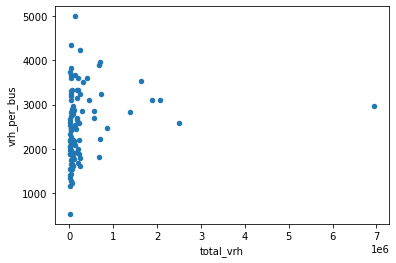

In [65]:
ntd_joined[['total_vrh', 'vrh_per_bus']].plot(x='total_vrh', y='vrh_per_bus', kind='scatter')

In [66]:
ntd_joined >> arrange(-_.vrh_per_bus)

,ntd_id,bus,artic_bus,otr_bus,dbl_deck_bus,trolleybus,Agency,total_vrh,total_buses,vrh_per_bus
39,90173,23,0,0,0,0,Transit Joint Powers Authority for Merced Coun...,114903,23,4995.782609
68,9R02-91047,9,0,0,0,0,Mendocino Transit Authority,39040,9,4337.777778
33,90211,55,0,0,0,0,Anaheim Transportation Network,232611,55,4229.290909
8,90031,173,0,0,0,0,Riverside Transit Agency,686321,173,3967.173410
12,90029,159,15,0,0,0,Omnitrans,676045,174,3885.316092
...,...,...,...,...,...,...,...,...,...,...
156,9R02-91058,6,0,0,0,0,City of Ojai,8041,6,1340.166667
48,9R02-91062,32,0,0,0,0,Eastern Sierra Transit Authority,40516,32,1266.125000
43,90205,46,0,0,0,0,City of Elk Grove,55961,46,1216.543478
28,9R02-91007,15,0,0,0,0,Fresno County Rural Transit Agency,17355,15,1157.000000


### Methodology notes

* filtered to buses
* all 2019 NTD data
* using 12 year useful life
* bus cost:
    * based on CARB Innovative Clean Transit cost model for a 40', 550kWh electric bus in 2022
    * Inclusive of charger and maintenance infrastructure upgrades, but not potential land aquisition costs for expanded facilities.

In [68]:
hours_by_operator

,,additional_service_hrs_annualized,annual_service_cost
calitp_itp_id,tract_type,,
182,urban,1.033321e+07,1.549981e+09
4,urban,3.315296e+06,4.972945e+08
142,urban,2.867758e+06,4.301638e+08
235,urban,2.867758e+06,4.301638e+08
294,urban,2.862238e+06,4.293357e+08
...,...,...,...
123,rural,1.057333e+03,1.586000e+05
287,rural,5.070000e+02,7.605000e+04
4,rural,0.000000e+00,0.000000e+00


In [71]:
bus_cost = 776941 ## https://ww2.arb.ca.gov/resources/documents/transit-fleet-cost-model

In [69]:
median_vrh_per_bus = ntd_joined['vrh_per_bus'].median()

In [75]:
hours_by_operator['additional_buses'] = hours_by_operator['additional_service_hrs_annualized'] / median_vrh_per_bus

In [76]:
hours_by_operator['bus_capex'] = hours_by_operator['additional_buses'] * bus_cost

In [81]:
hours_by_operator['bus_capex_annualized'] = hours_by_operator['bus_capex'] / 14 ## 14 year service life

In [82]:
hours_by_operator

,,additional_service_hrs_annualized,annual_service_cost,bus_capex,bus_capex_annualized,additional_buses
calitp_itp_id,tract_type,,,,,
182,urban,1.033321e+07,1.549981e+09,3.270757e+09,2.336255e+08,4209.787799
4,urban,3.315296e+06,4.972945e+08,1.049386e+09,7.495617e+07,1350.664256
142,urban,2.867758e+06,4.301638e+08,9.077278e+08,6.483770e+07,1168.335587
235,urban,2.867758e+06,4.301638e+08,9.077278e+08,6.483770e+07,1168.335587
294,urban,2.862238e+06,4.293357e+08,9.059804e+08,6.471288e+07,1166.086446
...,...,...,...,...,...,...
123,rural,1.057333e+03,1.586000e+05,3.346763e+05,2.390545e+04,0.430762
287,rural,5.070000e+02,7.605000e+04,1.604800e+05,1.146286e+04,0.206554
4,rural,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000


In [83]:
hours_by_operator.groupby('tract_type').sum()

,additional_service_hrs_annualized,annual_service_cost,bus_capex,bus_capex_annualized,additional_buses
tract_type,,,,,
rural,6.194919e+06,9.292379e+08,1.960870e+09,1.400621e+08,2523.833553
suburban,2.060605e+06,3.090907e+08,6.522406e+08,4.658861e+07,839.498194
urban,5.397544e+07,8.096315e+09,1.708477e+10,1.220341e+09,21989.796094


In [84]:
hours_by_operator.sum()

additional_service_hrs_annualized    6.223096e+07
annual_service_cost                  9.334644e+09
bus_capex                            1.969788e+10
bus_capex_annualized                 1.406992e+09
additional_buses                     2.535313e+04
dtype: float64

### Sandbox

In [85]:
# tbl.transitstacks.provider_info() >> select(_.calitp_itp_id == _.itp_id, _.ntd_id) >> collect() >> inner_join(_, ntd_joined, on='ntd_id')